In [ ]:
#Import Libraries
!pip install plotly==4.8.2

# importing the required libraries
import numpy as np 
import pandas as pd 
import random
import math
import time
from datetime import date, timedelta

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Model,Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Activation, Flatten, BatchNormalization,SeparableConv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers.convolutional import Conv2D, MaxPooling2D,Conv1D
from keras.layers.recurrent import LSTM

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# library to handle requests
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
from pandas import read_csv

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
# Visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
from folium.plugins import MarkerCluster, HeatMap
from folium import Marker

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12
# Disable warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline





     |████████████████████████████████| 11.5 MB 12.8 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=0d70438e7a5aebe4dd8df1ebf8143cfae746b50f096bb283a9dbd9b86ac85e87
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
#Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cummulative data
latest_data_owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/latest/owid-covid-latest.csv')

# df['DataFrame Column'] = df['DataFrame Column'].fillna(0)
latest_data_owid = latest_data_owid.apply(lambda x: x.fillna(0) if x.dtype.kind in 'float64' else x)

#Remove continent rows
to_drop = ['South America',
'Sint Maarten (Dutch part)',
'Africa',
'Asia',
'Europe',
'European Union',
'North America',	
'Northern Cyprus',
'International',
'World']
latest_data_owid = latest_data_owid[~latest_data_owid['location'].isin(to_drop)]

iso_to_drop = ['OWID_HIC'] 

# latest_data_owid = latest_data_owid[~latest_data_owid['iso_code'].isin(iso_to_drop)]
latest_data_owid = latest_data_owid[~latest_data_owid.iso_code.str.contains("OWID")]

# latest_data_owid['vaccinated_people_%'] = (latest_data_owid['people_vaccinated']/latest_data_owid['population'])*100

# latest_data_owid = latest_data_owid.drop(latest_data_owid.index[[1,10,66,65,93,147,184, 218,149]])

latest_data_owid = latest_data_owid.rename(columns={'total_vaccinations_per_hundred': 'total_vaccinations_%', 'people_vaccinated_per_hundred': 'people_vaccinated_%', 'people_fully_vaccinated_per_hundred': 'people_fully_vaccinated_%', 'total_boosters_per_hundred':'total_boosters_%'})

latest_data_owid.drop(["continent", "new_tests", "new_cases_smoothed","new_deaths_smoothed","new_cases_smoothed_per_million","new_deaths_smoothed_per_million",
                       "total_deaths_per_million", "new_deaths_per_million", "hosp_patients_per_million", "icu_patients_per_million","weekly_icu_admissions","weekly_icu_admissions_per_million","weekly_hosp_admissions","weekly_hosp_admissions_per_million",
                                          "total_tests_per_thousand", "new_tests_per_thousand", "new_tests_smoothed", "new_tests_smoothed_per_thousand",
                                          "tests_per_case", "tests_units", "new_vaccinations_smoothed", 
                                          "population_density",'reproduction_rate',"excess_mortality",
                                          "new_vaccinations_smoothed_per_million",	"stringency_index", "hospital_beds_per_thousand",
                       'median_age',	'aged_65_older'	,'aged_70_older'	,'gdp_per_capita',	'extreme_poverty'	,'cardiovasc_death_rate',	'diabetes_prevalence',	'female_smokers',	'male_smokers',	'handwashing_facilities',	'life_expectancy',	'human_development_index'],axis=1, inplace=True)

# latest_data_owid['last_updated_date'] = pd.to_datetime(latest_data_owid['last_updated_date'],format='%Y-%m-%d')


In [ ]:
#Data daily (since day 1)
covid_cases_owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
covid_cases_owid.drop(["continent"],axis=1, inplace=True)
covid_cases_owid = covid_cases_owid.apply(lambda x: x.fillna(0) if x.dtype.kind in 'float64' else x)
to_drop = ['South America',
'Sint Maarten (Dutch part)',
'Africa',
'Asia',
'Europe',
'European Union',
'North America',	
'Northern Cyprus',
'International',
'World']


covid_cases_owid = covid_cases_owid[~covid_cases_owid.iso_code.str.contains("OWID")]

covid_cases_owid = covid_cases_owid[~covid_cases_owid['location'].isin(to_drop)]

#rename cols
covid_cases_owid = covid_cases_owid.rename(columns={'total_vaccinations_per_hundred': 'total_vaccinations_%', 'people_vaccinated_per_hundred': 'people_vaccinated_%', 'people_fully_vaccinated_per_hundred': 'people_fully_vaccinated_%', 'total_boosters_per_hundred':'total_boosters_%'})


In [ ]:
# Drop some unused cols

covid_cases_owid.drop([ "new_tests",
                       "total_deaths_per_million",  "hosp_patients_per_million", "icu_patients_per_million","weekly_icu_admissions","weekly_icu_admissions_per_million","weekly_hosp_admissions","weekly_hosp_admissions_per_million",
                                          "total_tests_per_thousand", "new_tests_per_thousand", "new_tests_smoothed", "new_tests_smoothed_per_thousand",
                                          "tests_per_case", "tests_units", "new_vaccinations_smoothed", 
                                          "population_density",'reproduction_rate',"excess_mortality",
                                          "new_vaccinations_smoothed_per_million",	"stringency_index", "hospital_beds_per_thousand",
                       'median_age',	'aged_65_older'	,'aged_70_older'	,'gdp_per_capita',	'extreme_poverty'	,'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million','cardiovasc_death_rate',	'diabetes_prevalence',	'female_smokers',	'male_smokers',	'handwashing_facilities',	'life_expectancy',	'human_development_index'],axis=1, inplace=True)


In [ ]:
covid_cases_owid_US = covid_cases_owid.loc[covid_cases_owid['location']=='United States']


covid_cases_owid_US['new_cases_%'] = (covid_cases_owid_US['new_cases']/covid_cases_owid_US['population'])*100

covid_cases_owid_US = covid_cases_owid_US[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

 
covid_cases_owid_US.head()

,date,new_cases,new_deaths,new_cases_%,total_cases,total_deaths,population,new_cases_smoothed,new_cases_per_million,new_deaths_per_million,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
153489,2020-01-22,0.0,0.0,0.000000e+00,1.0,0.0,332915074.0,0.0,0.000,0.0,0.0,0.0
153490,2020-01-23,0.0,0.0,0.000000e+00,1.0,0.0,332915074.0,0.0,0.000,0.0,0.0,0.0
153491,2020-01-24,1.0,0.0,3.003769e-07,2.0,0.0,332915074.0,0.0,0.003,0.0,0.0,0.0
153492,2020-01-25,0.0,0.0,0.000000e+00,2.0,0.0,332915074.0,0.0,0.000,0.0,0.0,0.0
153493,2020-01-26,3.0,0.0,9.011307e-07,5.0,0.0,332915074.0,0.0,0.009,0.0,0.0,0.0


#### US

In [ ]:
df_total_death_US = covid_cases_owid_US[['date','total_deaths']]

df_total_death_US.head()

,date,total_deaths
153489,2020-01-22,0.0
153490,2020-01-23,0.0
153491,2020-01-24,0.0
153492,2020-01-25,0.0
153493,2020-01-26,0.0


In [ ]:
df_total_death_US.dtypes

date             object
total_deaths    float64
dtype: object

In [ ]:
dataset = df_total_death_US.iloc[:,1].values #using only deaths 
dataset.shape

(757,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset))   #train_size
dataset = dataset.reshape(-1,1)
#perform a robust scaler transform of the dataset
scaler = MinMaxScaler(feature_range=(0,1))
# Fit the scaler using available training data. 
# For normalization, this means the training data will be used to estimate 
# the minimum and maximum observable values. This is done by calling the fit() function.
scaler.fit(dataset[:split]) #fit only on the training data which is the first 80%
# Apply the scale to training data. 
# This means you can use the normalized data to train your model.
#  This is done by calling the transform() function.
# Apply the scale to data going forward. 
# This means you can prepare new data in the future on which you want to make predictions.
dataset_n = scaler.transform(dataset).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_n.shape


(757,)

In [ ]:
# convert an array of values into a dataset matrix and split the data
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).
# convert an array of values into a dataset matrix
# X		Y
# 112		148
# 119		132
# can see the X=t and Y=t+1 pattern

# and

# split the X and y in such a way that X will contain cases for a certain amount of 
# previous days 
# and y contains the reading for the next day.

# Time steps: seq_size or T or previous

def create_dataset(df,previous,split_ratio):
    X, Y = [], []
    for i in range(len(df)-previous):
        a = df[i:(i+previous)]
        X.append(a)
        y = df[i+previous]
        Y.append(y)
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y)
    N = len(X)
    split = round(split_ratio*len(df)) 
    X_train = X[:split]
    X_test = X[split:]
    Y_train = Y[:split]
    Y_test = Y[split:]
    print("X.shape", X.shape, "Y.shape", Y.shape)
    print("X_train.shape", X_train.shape, "Y_train.shape", Y_train.shape)
    print("X_test.shape", X_test.shape, "Y_test.shape", Y_test.shape)
    return X,X_train,X_test,Y,Y_train,Y_test

In [ ]:
#Building the model architecture
# Plot validation loss vs training loss to see how “good” or “bad” 
# a given predictor is at classifying the input data.
def plotLearningCurve(history,epochnum,batchnum):
  epochRange = range(1,epochnum+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  plt.plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Loss', fontsize = 15)
  plt.grid(color='gray', linestyle='--')
  plt.legend()
  plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
  plt.show()


In [ ]:
T = seq_size = 5  #number of past days used to predict the value for the current day
X,X_train,X_test,Y,Y_train,Y_test = create_dataset(dataset_n,T,0.8) #80% of data for training and 20% for testing

X.shape (752, 5, 1) Y.shape (752,)
X_train.shape (606, 5, 1) Y_train.shape (606,)
X_test.shape (146, 5, 1) Y_test.shape (146,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example
# LSTM(units=5, input_shape=(29907,1100), activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.0001))

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_size,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r = model.fit(X_train,
                    Y_train,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction])

Epoch 1/100
8/8 [==============================] - 10s 185ms/step - loss: 0.1808 - val_loss: 0.6684 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 0.1315 - val_loss: 0.4909 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 0.0698 - val_loss: 0.2502 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 0.0209 - val_loss: 0.0388 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 0.0292 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 44ms/step - loss: 0.0292 - val_loss: 0.0211 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 40ms/step - loss: 0.0174 - val_loss: 0.0171 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0111 - val_loss: 0.0013 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 46ms/step - loss: 0.0092 - val_loss: 2.4042e-05 - lr: 0.

In [ ]:
n_epochs = len(r.history['loss'])

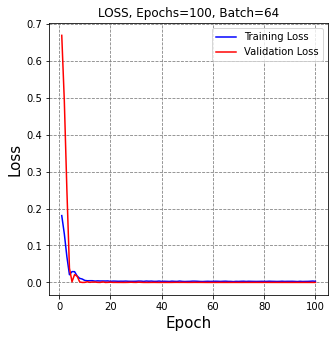

In [ ]:
plotLearningCurve(r,epochnum,batchnum)

In [ ]:
print("Train score:", model.evaluate(X_train,Y_train))
print("Test score:", model.evaluate(X_test,Y_test))


19/19 [==============================] - 0s 3ms/step - loss: 1.2886e-04
Train score: 0.00012885633623227477
5/5 [==============================] - 0s 4ms/step - loss: 0.0020
Test score: 0.0020011498127132654


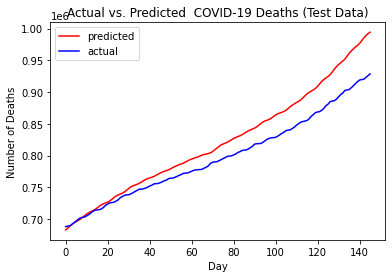

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred = model.predict(X_test)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred = scaler.inverse_transform(Y_pred)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred, color='red')
plt.plot(Y_test, color='blue')
plt.title('Actual vs. Predicted  COVID-19 Deaths (Test Data)')
plt.ylabel('Number of Deaths')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)
Y_pred = Y_pred.reshape(-1)

date_array = np.array(df_total_death_US['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1US = go.Scatter(
    x = date_train,
    y = Y_train,
    mode = 'lines',
    name = 'Data_US'
)
trace2US = go.Scatter(
    x = date_test,
    y = Y_pred,
    mode = 'lines',
    name = 'Prediction_US'
)
trace3US = go.Scatter(
    x = date_test,
    y = Y_test,
    mode='lines',
    name = 'Ground Truth_US'
)
layout = go.Layout(
    title = "<b>U.S. Death Tolls</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}
)
fig = go.Figure(data=[trace1US, trace2US, trace3US], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid cases to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list = dataset_n[-T:]  #take last 100 values from the dataset
num_prediction = 15 #predicting cases for next 15 days
for _ in range(num_prediction):
    x = prediction_list[-T:]
    x = x.reshape((1,T, 1))
    out = model.predict(x)[0][0]
    prediction_list = np.append(prediction_list, out) #appending the prediction
prediction_list = prediction_list[T-1:] 
prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1,1)).reshape(-1)


last_date = df_total_death_US['date'].values[-1]
prediction_dates = np.array(pd.date_range(last_date, periods=num_prediction+1))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates)


In [ ]:
trace1_US = go.Scatter(
    x = date_array,
    y = dataset.reshape(-1),
    mode = 'lines',
    name = 'Data_US'
)

trace2_US = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list,
    mode = 'lines',
    name = 'Forecast_US'
)
layout = go.Layout(
    title = "<b>U.S. Death Tolls Forecast</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}

)


fig = go.Figure(data=[trace1_US, trace2_US], layout=layout)
fig.show()

### Venezuela

In [ ]:
covid_cases_owid_VEN = covid_cases_owid.loc[covid_cases_owid['location']=='Venezuela']

covid_cases_owid_VEN['new_cases_%'] = (covid_cases_owid_VEN['new_cases']/covid_cases_owid_VEN['population'])*100

covid_cases_owid_VEN = covid_cases_owid_VEN[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

covid_cases_owid_VEN

,date,new_cases,new_deaths,new_cases_%,total_cases,total_deaths,population,new_cases_smoothed,new_cases_per_million,new_deaths_per_million,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
157590,2020-03-14,2.0,0.0,0.000007,2.0,0.0,28704947.0,0.000,0.070,0.000,0.000,0.000
157591,2020-03-15,8.0,0.0,0.000028,10.0,0.0,28704947.0,0.000,0.279,0.000,0.000,0.000
157592,2020-03-16,7.0,0.0,0.000024,17.0,0.0,28704947.0,0.000,0.244,0.000,0.000,0.000
157593,2020-03-17,16.0,0.0,0.000056,33.0,0.0,28704947.0,0.000,0.557,0.000,0.000,0.000
157594,2020-03-18,3.0,0.0,0.000010,36.0,0.0,28704947.0,0.000,0.105,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
158290,2022-02-12,1576.0,8.0,0.005490,503162.0,5529.0,28704947.0,1189.571,54.903,0.279,41.441,0.239
158291,2022-02-13,1557.0,9.0,0.005424,504719.0,5538.0,28704947.0,1205.143,54.242,0.314,41.984,0.254
158292,2022-02-14,1228.0,11.0,0.004278,505947.0,5549.0,28704947.0,1380.571,42.780,0.383,48.095,0.309
158293,2022-02-15,1030.0,7.0,0.003588,506977.0,5556.0,28704947.0,1285.714,35.882,0.244,44.791,0.304


In [ ]:
df_total_death_VEN = covid_cases_owid_VEN[['date','total_deaths']]

df_total_death_VEN.head()

,date,total_deaths
157590,2020-03-14,0.0
157591,2020-03-15,0.0
157592,2020-03-16,0.0
157593,2020-03-17,0.0
157594,2020-03-18,0.0


In [ ]:

dataset_VEN = df_total_death_VEN.iloc[:,1].values #using only confirmed cases
dataset_VEN.shape

(705,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset_VEN))   #train_size
dataset_VEN = dataset_VEN.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset_VEN[:split]) #fit only on the training data which is the first 80%
dataset_VEN_n = scaler.transform(dataset_VEN).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_VEN_n.shape


(705,)

In [ ]:
# T = seq_size = 10  #number of past days used to predict the value for the current day
X_VEN,X_train_VEN,X_test_VEN,Y_VEN,Y_train_VEN,Y_test_VEN = create_dataset(dataset_VEN_n,T,0.8) #80% of data for training and 20% for testing

X.shape (700, 5, 1) Y.shape (700,)
X_train.shape (564, 5, 1) Y_train.shape (564,)
X_test.shape (136, 5, 1) Y_test.shape (136,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example
# LSTM(units=5, input_shape=(29907,1100), activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.0001))

model_VEN = Sequential()
model_VEN.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(T,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
# model.add(Dense(32, activation='relu'))
model_VEN.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model_VEN.add(LSTM(64, activation='relu'))
model_VEN.add(Dropout(0.2))
model_VEN.add(Dense(1, activation='relu'))
model_VEN.compile(optimizer='adam', loss='mean_squared_error')

model_VEN.summary()
print('Train...')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction_VEN = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop_VEN = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r_VEN = model_VEN.fit(X_train_VEN,
                    Y_train_VEN,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction_VEN])

Epoch 1/100
8/8 [==============================] - 5s 91ms/step - loss: 0.0542 - val_loss: 0.5619 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0360 - val_loss: 0.4338 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0222 - val_loss: 0.2977 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0157 - val_loss: 0.1781 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0179 - val_loss: 0.1055 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0187 - val_loss: 0.0751 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0142 - val_loss: 0.0622 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0341 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0044 - val_loss: 0.0133 - lr: 0.0010
E

In [ ]:
n_epochs_VEN = len(r_VEN.history['loss'])

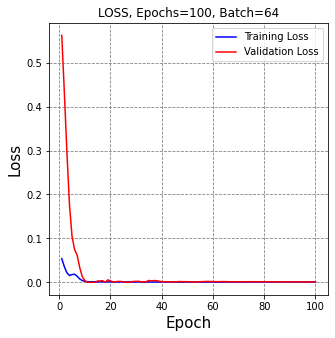

In [ ]:
plotLearningCurve(r_VEN,epochnum,batchnum)

In [ ]:
print("Train score:", model_VEN.evaluate(X_train_VEN,Y_train_VEN))
print("Test score:", model_VEN.evaluate(X_test_VEN,Y_test_VEN))


18/18 [==============================] - 0s 3ms/step - loss: 2.9058e-04
Train score: 0.00029058297513984144
5/5 [==============================] - 0s 5ms/step - loss: 6.8129e-04
Test score: 0.0006812858628109097


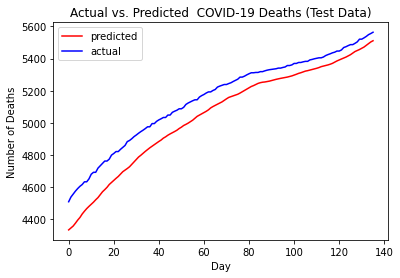

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred_VEN = model_VEN.predict(X_test_VEN)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred_VEN = scaler.inverse_transform(Y_pred_VEN)
Y_test_VEN = scaler.inverse_transform(Y_test_VEN.reshape(-1,1))
Y_train_VEN = scaler.inverse_transform(Y_train_VEN.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred_VEN, color='red')
plt.plot(Y_test_VEN, color='blue')
plt.title('Actual vs. Predicted  COVID-19 Deaths (Test Data)')
plt.ylabel('Number of Deaths')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train_VEN = Y_train_VEN.reshape(-1)
Y_test_VEN = Y_test_VEN.reshape(-1)
Y_pred_VEN = Y_pred_VEN.reshape(-1)

date_array = np.array(df_total_death_VEN['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1VEN = go.Scatter(
    x = date_train,
    y = Y_train_VEN,
    mode = 'lines',
    name = 'Data_VEN'
)
trace2VEN = go.Scatter(
    x = date_test,
    y = Y_pred_VEN,
    mode = 'lines',
    name = 'Prediction_VEN'
)
trace3VEN = go.Scatter(
    x = date_test,
    y = Y_test_VEN,
    mode='lines',
    name = 'Ground Truth_VEN'
)

layout = go.Layout(
    title = "<b>Venezuala Death Tolls</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}
)

fig = go.Figure(data=[trace1VEN, trace2VEN, trace3VEN], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid deaths to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list_VEN = dataset_VEN_n[-T:]  #take last 100 values from the dataset
num_prediction = 15 #predicting cases for next 15 days
for _ in range(num_prediction):
    x = prediction_list_VEN[-T:]
    x = x.reshape((1,T, 1))
    out = model_VEN.predict(x)[0][0]
    prediction_list_VEN = np.append(prediction_list_VEN, out) #appending the prediction
prediction_list_VEN = prediction_list_VEN[T-1:] 
prediction_list_VEN = scaler.inverse_transform(np.array(prediction_list_VEN).reshape(-1,1)).reshape(-1)


last_date_VEN = df_total_death_VEN['date'].values[-1]
prediction_dates_VEN = np.array(pd.date_range(last_date_VEN, periods=num_prediction+1))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates_VEN)


In [ ]:
trace1_VEN = go.Scatter(
    x = date_array,
    y = dataset_VEN.reshape(-1),
    mode = 'lines',
    name = 'Data_VEN'
)

trace2_VEN = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list_VEN,
    mode = 'lines',
    name = 'Forecast_VEN'
)
layout = go.Layout(
    title = "<b>Venezuala Death Tolls Forecast</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}

)
fig = go.Figure(data=[trace1_VEN, trace2_VEN], layout=layout)
fig.show()

### Germany

In [ ]:
covid_cases_owid_GE = covid_cases_owid.loc[covid_cases_owid['location']=='Germany']


covid_cases_owid_GE['new_cases_%'] = (covid_cases_owid_GE['new_cases']/covid_cases_owid_GE['population'])*100

covid_cases_owid_GE = covid_cases_owid_GE[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

 
covid_cases_owid_GE.head()

,date,new_cases,new_deaths,new_cases_%,total_cases,total_deaths,population,new_cases_smoothed,new_cases_smoothed,new_cases_per_million,new_deaths_per_million,new_cases_smoothed_per_million,new_deaths_smoothed_per_million
56141,2020-01-27,1.0,0.0,0.000001,1.0,0.0,83900471.0,0.0,0.0,0.012,0.0,0.0,0.0
56142,2020-01-28,3.0,0.0,0.000004,4.0,0.0,83900471.0,0.0,0.0,0.036,0.0,0.0,0.0
56143,2020-01-29,0.0,0.0,0.000000,4.0,0.0,83900471.0,0.0,0.0,0.000,0.0,0.0,0.0
56144,2020-01-30,0.0,0.0,0.000000,4.0,0.0,83900471.0,0.0,0.0,0.000,0.0,0.0,0.0
56145,2020-01-31,1.0,0.0,0.000001,5.0,0.0,83900471.0,0.0,0.0,0.012,0.0,0.0,0.0


In [ ]:
df_total_death_GE = covid_cases_owid_GE[['date','total_deaths']]

df_total_death_GE.tail()

,date,total_deaths
56888,2022-02-12,119939.0
56889,2022-02-13,119981.0
56890,2022-02-14,120227.0
56891,2022-02-15,120277.0
56892,2022-02-16,120732.0


In [ ]:
dataset_GE = df_total_death_GE.iloc[:,1].values #using only deaths 
dataset_GE.shape

(752,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset_GE))   #train_size
dataset_GE = dataset_GE.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset_GE[:split]) #fit only on the training data which is the first 80%
dataset_GE_n = scaler.transform(dataset_GE).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_GE_n.shape


(752,)

In [ ]:
# T = seq_size = 10  #number of past days used to predict the value for the current day
X_GE,X_train_GE,X_test_GE,Y_GE,Y_train_GE,Y_test_GE = create_dataset(dataset_GE_n,T,0.8) #80% of data for training and 20% for testing

X.shape (747, 5, 1) Y.shape (747,)
X_train.shape (602, 5, 1) Y_train.shape (602,)
X_test.shape (145, 5, 1) Y_test.shape (145,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example
# LSTM(units=5, input_shape=(29907,1100), activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.0001))

model_GE = Sequential()
model_GE.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(T,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
# model.add(Dense(32, activation='relu'))
model_GE.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model_GE.add(LSTM(64, activation='relu'))
model_GE.add(Dropout(0.2))
model_GE.add(Dense(1, activation='relu'))
model_GE.compile(optimizer='adam', loss='mean_squared_error')

model_GE.summary()
print('Train...')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout_4 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction_GE = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r_GE = model_GE.fit(X_train_GE,
                    Y_train_GE,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction_GE])

Epoch 1/100
8/8 [==============================] - 5s 91ms/step - loss: 0.1639 - val_loss: 0.8364 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1377 - val_loss: 0.7234 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1105 - val_loss: 0.5892 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0839 - val_loss: 0.4343 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0601 - val_loss: 0.2765 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0472 - val_loss: 0.1477 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0409 - val_loss: 0.0700 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0290 - val_loss: 0.0281 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0141 - val_loss: 0.0063 - lr: 0.0010
E

In [ ]:
n_epochs_GE = len(r_GE.history['loss'])
n_epochs_GE

100

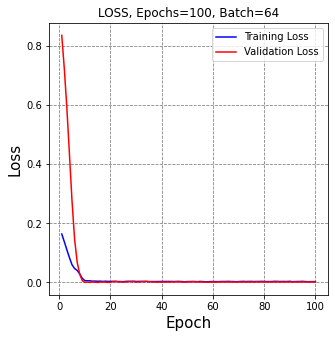

In [ ]:
plotLearningCurve(r_GE,epochnum,batchnum)

In [ ]:
print("Train score:", model_GE.evaluate(X_train_GE,Y_train_GE))
print("Test score:", model_GE.evaluate(X_test_GE,Y_test_GE))


19/19 [==============================] - 0s 4ms/step - loss: 5.0068e-04
Train score: 0.0005006801220588386
5/5 [==============================] - 0s 4ms/step - loss: 0.0051
Test score: 0.005110394209623337


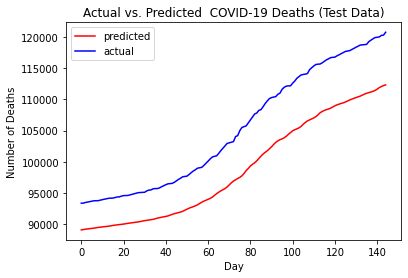

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred_GE = model_GE.predict(X_test_GE)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred_GE = scaler.inverse_transform(Y_pred_GE)
Y_test_GE = scaler.inverse_transform(Y_test_GE.reshape(-1,1))
Y_train_GE = scaler.inverse_transform(Y_train_GE.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred_GE, color='red')
plt.plot(Y_test_GE, color='blue')
plt.title('Actual vs. Predicted  COVID-19 Deaths (Test Data)')
plt.ylabel('Number of Deaths')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train_GE = Y_train_GE.reshape(-1)
Y_test_GE = Y_test_GE.reshape(-1)
Y_pred_GE = Y_pred_GE.reshape(-1)

date_array = np.array(df_total_death_GE['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1GE = go.Scatter(
    x = date_train,
    y = Y_train_GE,
    mode = 'lines',
    name = 'Data_GE'
)
trace2GE = go.Scatter(
    x = date_test,
    y = Y_pred_GE,
    mode = 'lines',
    name = 'Prediction_GE'
)
trace3GE = go.Scatter(
    x = date_test,
    y = Y_test_GE,
    mode='lines',
    name = 'Ground Truth_GE'
)
layout = go.Layout(
    title = "<b>Germany Death Tolls</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}
)
fig = go.Figure(data=[trace1GE, trace2GE, trace3GE], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid deaths to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list_GE = dataset_GE_n[-T:]  #take last 100 values from the dataset
num_prediction = 15 #predicting cases for next 15 days
for _ in range(num_prediction):
    x = prediction_list_GE[-T:]
    x = x.reshape((1,T, 1))
    out = model_GE.predict(x)[0][0]
    prediction_list_GE = np.append(prediction_list_GE, out) #appending the prediction
prediction_list_GE = prediction_list_GE[T-1:] 
prediction_list_GE = scaler.inverse_transform(np.array(prediction_list_GE).reshape(-1,1)).reshape(-1)


last_date_GE = df_total_death_GE['date'].values[-1]
prediction_dates_GE = np.array(pd.date_range(last_date_GE, periods=num_prediction+1))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates_GE)


In [ ]:
trace1_GE = go.Scatter(
    x = date_array,
    y = dataset_GE.reshape(-1),
    mode = 'lines',
    name = 'Data_GE'
)

trace2_GE = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list_GE,
    mode = 'lines',
    name = 'Forecast_GE'
)

layout = go.Layout(
    title = "<b>Germany Death Tolls Forecast</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}

)
fig = go.Figure(data=[trace1_GE, trace2_GE], layout=layout)
fig.show()

> ### **Haiti**

In [ ]:
covid_cases_owid_HAT = covid_cases_owid.loc[covid_cases_owid['location']=='Haiti']
covid_cases_owid_HAT['new_cases_%'] = (covid_cases_owid_HAT['new_cases']/covid_cases_owid_HAT['population'])*100

covid_cases_owid_HAT = covid_cases_owid_HAT[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

# covid_cases_owid_HAT

In [ ]:
df_total_death_HAT = covid_cases_owid_HAT[['date','total_deaths']]

df_total_death_HAT.head()

,date,total_deaths
63664,2020-03-20,0.0
63665,2020-03-21,0.0
63666,2020-03-22,0.0
63667,2020-03-23,0.0
63668,2020-03-24,0.0


In [ ]:
dataset_HAT = df_total_death_HAT.iloc[:,1].values #using only confirmed cases
dataset_HAT.shape

(699,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset_HAT))   #train_size
dataset_HAT = dataset_HAT.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset_HAT[:split]) #fit only on the training data which is the first 80%
dataset_HAT_n = scaler.transform(dataset_HAT).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_HAT_n.shape


(699,)

In [ ]:
# T = seq_size = 10  #number of past days used to predict the value for the current day
X_HAT,X_train_HAT,X_test_HAT,Y_HAT,Y_train_HAT,Y_test_HAT = create_dataset(dataset_HAT_n,T,0.8) #80% of data for training and 20% for testing

X.shape (694, 5, 1) Y.shape (694,)
X_train.shape (559, 5, 1) Y_train.shape (559,)
X_test.shape (135, 5, 1) Y_test.shape (135,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example
# LSTM(units=5, input_shape=(29907,1100), activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.0001))

model_HAT = Sequential()
model_HAT.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(T,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
# model.add(Dense(32, activation='relu'))
model_HAT.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model_HAT.add(LSTM(64, activation='relu'))
model_HAT.add(Dropout(0.2))
model_HAT.add(Dense(1, activation='relu'))
model_HAT.compile(optimizer='adam', loss='mean_squared_error')

model_HAT.summary()
print('Train...')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout_6 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction_HAT = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r_HAT = model_HAT.fit(X_train_HAT,
                    Y_train_HAT,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction_HAT])

Epoch 1/100
7/7 [==============================] - 5s 99ms/step - loss: 0.1069 - val_loss: 0.6997 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0821 - val_loss: 0.5857 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0534 - val_loss: 0.4322 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0245 - val_loss: 0.2519 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0095 - val_loss: 0.1063 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0134 - val_loss: 0.0704 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0135 - val_loss: 0.0977 - lr: 0.0010
Epoch 8/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0114 - val_loss: 0.1062 - lr: 0.0010
Epoch 9/100
5/7 [====================>.........] - ETA: 0s - loss: 0.0093
Epoch 9: ReduceLROnPlateau reducing le

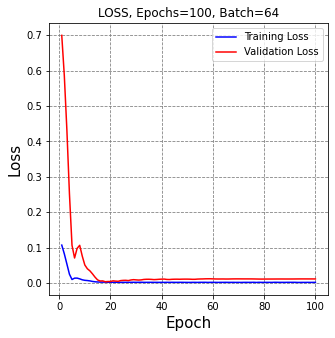

In [ ]:
plotLearningCurve(r_HAT,epochnum,batchnum)

In [ ]:
print("Train score:", model_HAT.evaluate(X_train_HAT,Y_train_HAT))
print("Test score:", model_HAT.evaluate(X_test_HAT,Y_test_HAT))


18/18 [==============================] - 0s 4ms/step - loss: 0.0023
Train score: 0.002313825534656644
5/5 [==============================] - 0s 4ms/step - loss: 0.0151
Test score: 0.015098847448825836


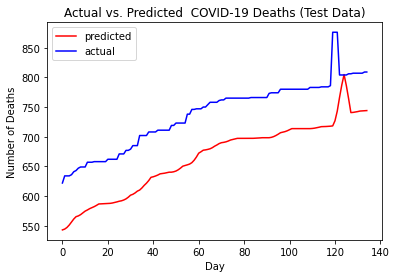

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred_HAT = model_HAT.predict(X_test_HAT)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred_HAT = scaler.inverse_transform(Y_pred_HAT)
Y_test_HAT= scaler.inverse_transform(Y_test_HAT.reshape(-1,1))
Y_train_HAT = scaler.inverse_transform(Y_train_HAT.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred_HAT, color='red')
plt.plot(Y_test_HAT, color='blue')
plt.title('Actual vs. Predicted  COVID-19 Deaths (Test Data)')
plt.ylabel('Number of Deaths')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train_HAT = Y_train_HAT.reshape(-1)
Y_test_HAT = Y_test_HAT.reshape(-1)
Y_pred_HAT = Y_pred_HAT.reshape(-1)

date_array = np.array(df_total_death_HAT['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1HAT = go.Scatter(
    x = date_train,
    y = Y_train_HAT,
    mode = 'lines',
    name = 'Data_HAT'
)
trace2HAT = go.Scatter(
    x = date_test,
    y = Y_pred_HAT,
    mode = 'lines',
    name = 'Prediction_HAT'
)
trace3HAT = go.Scatter(
    x = date_test,
    y = Y_test_HAT,
    mode='lines',
    name = 'Ground Truth_HAT'
)
layout = go.Layout(
    title = "<b>Haiti Death Tolls</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}
)
fig = go.Figure(data=[trace1HAT, trace2HAT, trace3HAT], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid cases to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list_HAT = dataset_HAT_n[-T:]  #take last 100 values from the dataset
num_prediction = 15 #predicting cases for next 15 days
for _ in range(num_prediction):
    x = prediction_list_HAT[-T:]
    x = x.reshape((1,T, 1))
    out = model_HAT.predict(x)[0][0]
    prediction_list_HAT = np.append(prediction_list_HAT, out) #appending the prediction
prediction_list_HAT = prediction_list_HAT[T-1:] 
prediction_list_HAT = scaler.inverse_transform(np.array(prediction_list_HAT).reshape(-1,1)).reshape(-1)


last_date_HAT = df_total_death_HAT['date'].values[-1]
prediction_dates_HAT = np.array(pd.date_range(last_date_HAT, periods=num_prediction+1))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates_HAT)


In [ ]:
trace1_HAT = go.Scatter(
    x = date_array,
    y = dataset_HAT.reshape(-1),
    mode = 'lines',
    name = 'Data_HAT'
)

trace2_HAT = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list_HAT,
    mode = 'lines',
    name = 'Forecast_HAT'
)
layout = go.Layout(
    title = "<b>Haiti Death Tolls Forecast</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Number of Deaths"}
)
fig = go.Figure(data=[trace1_HAT, trace2_HAT], layout=layout)
fig.show()

In [ ]:
from plotly.subplots import make_subplots


In [ ]:
fig = make_subplots(rows=2, cols=2)
fig.update_layout(template='plotly_dark')

fig.add_trace(trace1US,1,1)
fig.add_trace(trace2US,1,1)
fig.add_trace(trace3US,1,1)
#----------------------------------------------------------------------
fig.add_trace(trace1VEN,1,2)
fig.add_trace(trace2VEN,1,2)
fig.add_trace(trace3VEN,1,2)
#----------------------------------------------------------------------
fig.add_trace(trace1GE,2,1)
fig.add_trace(trace2GE,2,1)
fig.add_trace(trace3GE,2,1)
#----------------------------------------------------------------------
fig.add_trace(trace1HAT,2,2)
fig.add_trace(trace2HAT,2,2)
fig.add_trace(trace3HAT,2,2)
#----------------------------------------------------------------------
fig.update_layout(template='plotly_dark',
                  title = 'COVID-19 Total Deaths Prediction',
                  annotations=[]
                 )

In [ ]:
fig = make_subplots(rows=2, cols=2)
fig.update_layout(template='plotly_dark')

fig.add_trace(trace1_US,1,1)
fig.add_trace(trace2_US,1,1)
#----------------------------------------------------------------------
fig.add_trace(trace1_VEN,1,2)
fig.add_trace(trace2_VEN,1,2)
#----------------------------------------------------------------------
fig.add_trace(trace1_GE,2,1)
fig.add_trace(trace2_GE,2,1)
#----------------------------------------------------------------------
fig.add_trace(trace1_HAT,2,2)
fig.add_trace(trace2_HAT,2,2)
#----------------------------------------------------------------------
fig.update_layout(template='plotly_dark',
                  title = 'COVID-19 Total Deaths 16-Day Forecast',
                  annotations=[]
                 )